Tabular Q learning

Direcetely run saved parameters in render block! 

In [19]:
# Import env
import gym, gym_unbalanced_disk, time



Discrete wrapper

In [20]:
import numpy as np
from gym import spaces

class DiscretizeWrapper(gym.Wrapper):
    def __init__(self, env,num_obs=[50,50,40],num_act=10): # three state(sin(angle),cos(angle),angular velocity), 1 input(voltage)
        super(DiscretizeWrapper,self).__init__(env)
        self.num_obs=np.array(num_obs)
        self.num_act=np.array(num_act)
        # define new spaces
        self.observation_space = spaces.MultiDiscrete(self.num_obs)
        self.action_space = spaces.Discrete(self.num_act)

        self.olow, self.ohigh = env.observation_space.low, env.observation_space.high
        self.alow, self.ahigh = env.action_space.low, env.action_space.high
        #print(self.olow,self.ohigh) #[ -1.  -1. -40.] [ 1.  1. 40.]
        #print(self.alow, self.ahigh ) # -3.0 3.0

        # action discrete list.
        self.stepsize = (self.ahigh-self.alow)/self.num_act
        self.values_list = np.arange(self.alow,self.ahigh,self.stepsize)

    def discretize_obs(self,observation):
        #scale_obs = (observation-self.olow)/(self.ohigh-self.olow)
        #mid=((scale_obs*self.num_obs))#.astype(int)       
        step = (self.ohigh-self.olow)/self.num_obs
    
        values_list_1 = np.arange(self.olow[0],self.ohigh[0],step[0])
        values_list_2 = np.arange(self.olow[1],self.ohigh[1],step[1])
        values_list_3 = np.arange(self.olow[2],self.ohigh[2],step[2])
        #print(values_list_3)

        out_1 = round(values_list_1[np.abs(values_list_1-observation[0]).argmin()],4) # obs-list the min one is the closet value, so choose it index and find it
        out_2 = round(values_list_2[np.abs(values_list_2-observation[1]).argmin()],4)
        out_3 = round(values_list_3[np.abs(values_list_3-observation[2]).argmin()],4)
        return  tuple([out_1,out_2,out_3])
    
    def discretize_act(self,action):
        #scale_act = (action-self.alow)/(self.ahigh-self.alow)
        #mid = ((scale_act*self.num_act))#.astype(int)
        stepsize = (self.ahigh-self.alow)/self.num_act
        values_list = np.arange(self.alow,self.ahigh,stepsize)
        out = values_list[np.abs(values_list-action).argmin()] 
        return round(out,4)


    def step(self,action):
        action_discretized = self.discretize_act(action)
        #print(action_disretized)
        observation, reward, done, info = self.env.step(action_discretized)  #self.reward_fun = lambda self: np.exp(-(self.th%(2*np.pi)-np.pi)**2/(2*(np.pi/7)**2)) #example reward function
        
        velocity = abs(observation[2])
        reward_vel = velocity/40*np.exp(-abs(np.pi-self.th%(2*np.pi))) # /40 to reduce -> (0,1) 
        reward_th =  np.exp(- (np.pi-self.th%(2*np.pi))**2/(2*(np.pi/10)**2)) # **2 so no abs here!
        #reward= reward + np.exp(- (np.exp(-abs(self.env.th % (2*np.pi)-np.pi))) *(velocity - 40)**2 / (2*(np.pi/7)**2)) # add speed reward 
        #reward =  reward_th #  0.8*reward_vel +
        #print(observation)
        if abs(np.pi-self.th %(2*np.pi))< 0.13 and self.omega <0.1: # close to pi
            reward = 10+2*reward_th
        #elif abs(np.pi-self.th %(2*np.pi)) < 1 and abs(np.pi-self.th %(2*np.pi)) >0.2 and self.omega>0.1: # higher than 2/3 pi
            #reward = 2+ reward_th *2 
        elif abs(np.pi-self.th %(2*np.pi))>2.2 and self.omega< 0.5:  # lower than > 1/3 pi
            reward = -10 + 2*reward_th
        else:
            reward =  2*reward_th

        observation_discretized = self.discretize_obs(observation)
        return observation_discretized,reward,done,info

    def reset(self):
        return self.discretize_obs(self.env.reset()) # casue reset return obs
    


Q learning structure

In [21]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])   # return index

def roll_mean(ar,start=2000,N=50): #smoothing if needed
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out



##########

def Qlearn_tab(env_new,env_old,nsteps=8000,callbackfreq=100,alpha=0.2,eps=0.8,gamma=0.9):
    from collections import defaultdict
    Qmat = defaultdict(float)
    episode_lengths =[]
    episode_len_steps=[]
    obs_record=[]
    step_count=[]
    reward_record=[]


    obs = env_new.reset()  # already discretized  like (0.0, 0.98, 0.0)
    print('Goal reached time:')
    count = 0
    for z in range(nsteps):
        if np.random.uniform()<eps:
            action = env_new.discretize_act(env_old.action_space.sample()) # need discrete action space
        else:
            action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])] # -3.0,-2.98,...3 #convert to list for len
        
        obs_new, reward, done, info = env_new.step(action) ##input action have used discreted value, step will do action discrete again, double discrete, but fine.
        count+=1
        

        if done and not info.get('TimeLimit.truncated',False): # finish, done and time didn't out
            # save
            print(env_new._elapsed_steps,end=' ')
            # episode_lengths.append(env_new._elapsed_steps)
            # episode_len_steps.append(z)

            # update Q tabular
            TD = reward - Qmat[obs,action] # TD
            Qmat[obs,action]+=alpha*TD
            obs=env_new.reset()
            print('goal reached')
            

        else:  # before done,   time out or not
            #next_action = env_new.values_list[argmax([Qmat[obs_new, i] for i in env_new.values_list])]
            TD = reward + gamma*max(Qmat[obs_new,i] for i in env_new.values_list) -Qmat[obs,action]
            Qmat[obs,action]+=alpha*TD
            obs = obs_new

            if count % callbackfreq ==0:
                obs_record.append(obs)
                step_count.append(count)
                reward_record.append(reward)


            if info.get('TimeLimit.truncated',False):
                # save 
                # episode_lengths.append(env_new._elapsed_steps)
                # episode_len_steps.append(z)
                print('out',end=' ')

                obs = env_new.reset()
    print()
    return Qmat,np.array(obs_record),np.array(step_count),np.array(reward_record) #np.array(episode_lengths),np.array(episode_len_steps)





Training block, uncomment it when need a new Qmat

In [22]:
from matplotlib import pyplot as plt   # 
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)         

env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=2_000)
num_act=3
env_new = DiscretizeWrapper(env,num_obs=[20,20,40],num_act=num_act)

print('num_act=',num_act)
#Qmat, ep_lengths_steps, ep_lengths = Qlearn_tab(env_new=env_new,env_old=env, nsteps=400_000)
Qmat,obs_record,step_count,reward_record = Qlearn_tab(env_new=env_new,env_old=env, nsteps=50_000,alpha=0.7,eps=0.1,gamma=0.99)




###Big notice, env UnbalancedDisk  setp will always output False, means  done is always False , cause, it dosen't reach the goal at all!


Render

In [24]:
import pickle
from collections import defaultdict
import os
## load the Qmat (only for Qmat already saved)
# 
# file_path = os.path.join("saved_model", "my_Qmat.pkl")
# with open(file_path, 'rb') as file:
#     Qmat = pickle.load(file)

env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)         
#env = gym.make('unbalanced-disk-exp-sincos-v0',dt=0.025, umax=3.)

env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=2_000)
num_act=3
env_new = DiscretizeWrapper(env,num_obs=[20,20,40],num_act=num_act)


obs = env_new.reset()  # 
cum = 0
cum_rewards = []
reward_record =[]
th=[]
vel=[]
try:                   # 既然没法通过goal reach time来看出哪个更好，明显我们需要看数据！每隔一段时间打印state，而不是看流逝的时间！！ print state ,done
    env_new.render()    
    done= False
    while done==False:
        action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])]
        obs, reward, done, info = env_new.step(action)
        cum +=reward
        cum_rewards.append(cum)
        reward_record.append(reward)
        th.append(env_new.th%(2*np.pi)) 
        vel.append(env_new.omega)

        env.render()
        time.sleep(1/60)
        print(obs,reward,action,done,info)
finally:
    env_new.close()



pygame 2.3.0 (SDL 2.24.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
(-0.0, 0.9, -2.0) -10.0 -3.0 False {}
(-0.1, 0.9, -4.0) -10.0 -3.0 False {}
(-0.2, 0.9, -4.0) -10.0 -1.0 False {}
(-0.3, 0.9, -4.0) -10.0 -3.0 False {}
(-0.4, 0.9, -4.0) -10.0 -1.0 False {}
(-0.5, 0.9, -4.0) -9.999999999999998 -3.0 False {}
(-0.6, 0.8, -4.0) -9.99999999999999 -1.0 False {}
(-0.6, 0.8, -4.0) -9.999999999999917 -3.0 False {}
(-0.7, 0.7, -2.0) -9.999999999999465 -3.0 False {}
(-0.7, 0.7, 0.0) -9.999999999998836 1.0 False {}
(-0.7, 0.7, 2.0) 6.590186321453762e-13 -1.0 False {}
(-0.7, 0.8, 2.0) 2.561820780698743e-13 -3.0 False {}
(-0.6, 0.8, 4.0) 4.6338587501995667e-14 1.0 False {}
(-0.5, 0.9, 4.0) 2.692427531983361e-15 -1.0 False {}
(-0.4, 0.9, 6.0) 5.518199083285733e-17 1.0 False {}
(-0.2, 0.9, 6.0) 4.8256308839596425e-19 -1.0 False {}
(-0.1, 0.9, 8.0) 2.41200898834268e-21 1.0 False {}
(0.1, 0.9, 8.0) 2.1346256733123512e-20 1.0 False {}
(0.3, 0.9, 6.0) 3.022687

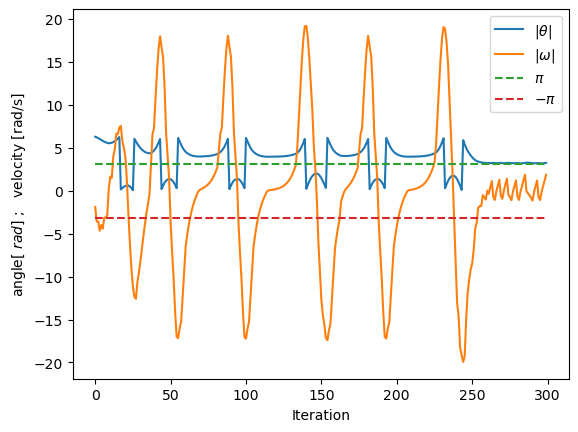

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


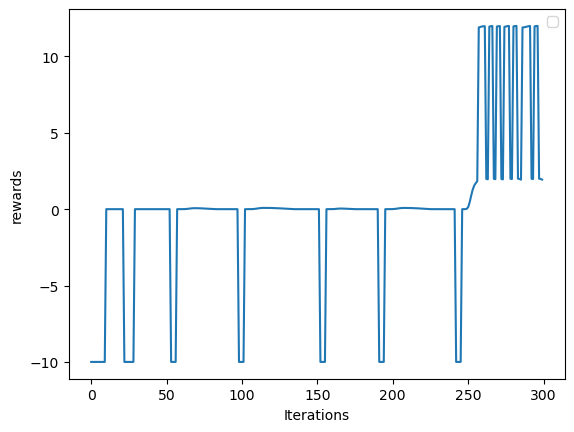

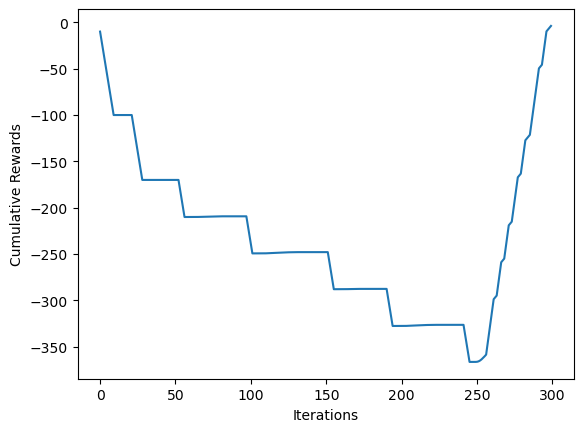

In [25]:
import matplotlib.pyplot as plt
plt.plot(th,label='$|\\theta|$')
plt.plot(vel,label='$|\omega|$')
plt.plot([np.pi]*len(th),'--',label='$\pi$')
plt.plot([-np.pi]*len(th),'--',label='$-\pi$')
plt.xlabel('Iteration')
plt.ylabel(r'angle[$\ rad$] ;   velocity [rad/s]')
plt.legend()
plt.show()

plt.plot(reward_record)
plt.xlabel('Iterations')
plt.ylabel('rewards')
plt.legend()
plt.show()

plt.plot(cum_rewards)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()